# **Telecom X – Parte 2: Prevendo Churn**

# 🧠 1. Preparação e Importação de Bibliotecas

In [1]:
# 1. Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

# 📁 2. Carregamento e Visualização Inicial dos Dados

In [2]:
# 2. Leitura do dataset
df = pd.read_csv("/content/telecomX_dados_tratados.csv")

# 3. Visualização rápida
print(df.head())
print(df.info())

   customerid  churn  gender  seniorcitizen  partner  dependents  tenure  \
0  0002-ORFBO      0       0              0        1           1       9   
1  0003-MKNFE      0       1              0        0           0       9   
2  0004-TLHLJ      1       1              0        0           0       4   
3  0011-IGKFF      1       1              1        1           0      13   
4  0013-EXCHZ      1       0              1        1           0       3   

   phoneservice  multiplelines internetservice  ...  deviceprotection  \
0             1              0             DSL  ...                 0   
1             1              1             DSL  ...                 0   
2             1              0     Fiber optic  ...                 1   
3             1              0     Fiber optic  ...                 1   
4             1              0     Fiber optic  ...                 0   

   techsupport  streamingtv  streamingmovies        contract  \
0            1            1             

# 🧹 3. Pré-processamento dos Dados

3.1. Remoção de coluna irrelevante

In [3]:
df = df.drop('customerid', axis=1)

3.2. Encoding de variáveis categóricas

In [6]:
# Identificar colunas categóricas
categorical_cols_to_encode = [col for col in ['internetservice', 'paymentmethod', 'contract'] if col in df.columns and df[col].dtype in ['object', 'bool']]


# Apply one-hot encoding to the identified columns
if categorical_cols_to_encode:
    df = pd.get_dummies(df, columns=categorical_cols_to_encode, drop_first=True)

# Display the first few rows and info after encoding to verify
print(df.head())
print(df.info())

   churn  gender  seniorcitizen  partner  dependents  tenure  phoneservice  \
0      0       0              0        1           1       9             1   
1      0       1              0        0           0       9             1   
2      1       1              0        0           0       4             1   
3      1       1              1        1           0      13             1   
4      1       0              1        1           0       3             1   

   multiplelines  onlinesecurity  onlinebackup  ...  charges.monthly  \
0              0               0             1  ...             65.6   
1              1               0             0  ...             59.9   
2              0               0             0  ...             73.9   
3              0               0             1  ...             98.0   
4              0               0             0  ...             83.9   

   charges.total  contas_diarias  internetservice_Fiber optic  \
0         593.30        2.186667 

3.3 Verificação da proporção de evasão

In [7]:
print("\nProporção de evasão (churn):")
print(df['churn'].value_counts(normalize=True))


Proporção de evasão (churn):
churn
0    0.74281
1    0.25719
Name: proportion, dtype: float64


# ⚖️ 4. Análise Exploratória e Correlação

4.1 Análise de correlação

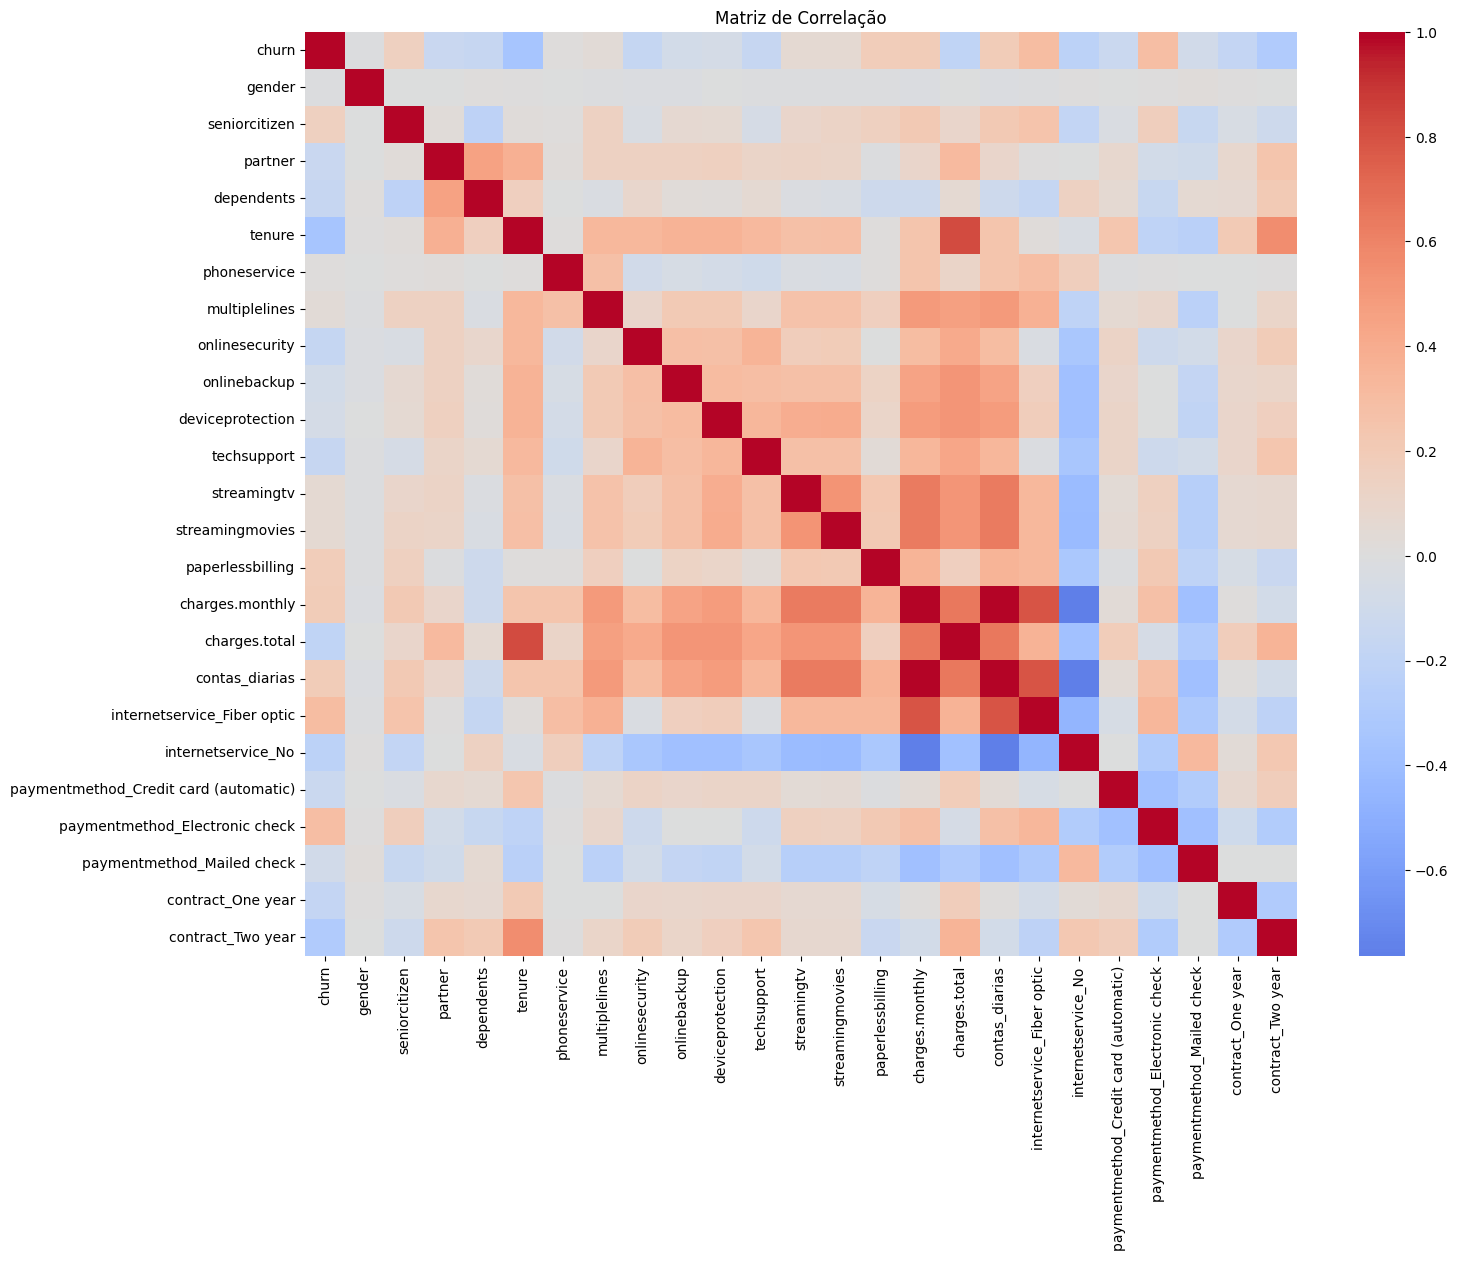


Correlações com churn:
churn                                    1.000000
internetservice_Fiber optic              0.300949
paymentmethod_Electronic check           0.294626
contas_diarias                           0.189866
charges.monthly                          0.189866
paperlessbilling                         0.186666
seniorcitizen                            0.146733
streamingtv                              0.062430
streamingmovies                          0.060586
multiplelines                            0.039343
phoneservice                             0.012571
gender                                  -0.009555
deviceprotection                        -0.063452
onlinebackup                            -0.080163
paymentmethod_Mailed check              -0.090061
paymentmethod_Credit card (automatic)   -0.131085
partner                                 -0.148546
techsupport                             -0.160440
dependents                              -0.161384
onlinesecurity            

In [8]:
plt.figure(figsize=(16, 12))
corr = df.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title('Matriz de Correlação')
plt.show()

# Correlações com churn (ordenadas)
print("\nCorrelações com churn:")
print(corr['churn'].sort_values(ascending=False))

4.2 Análises direcionadas

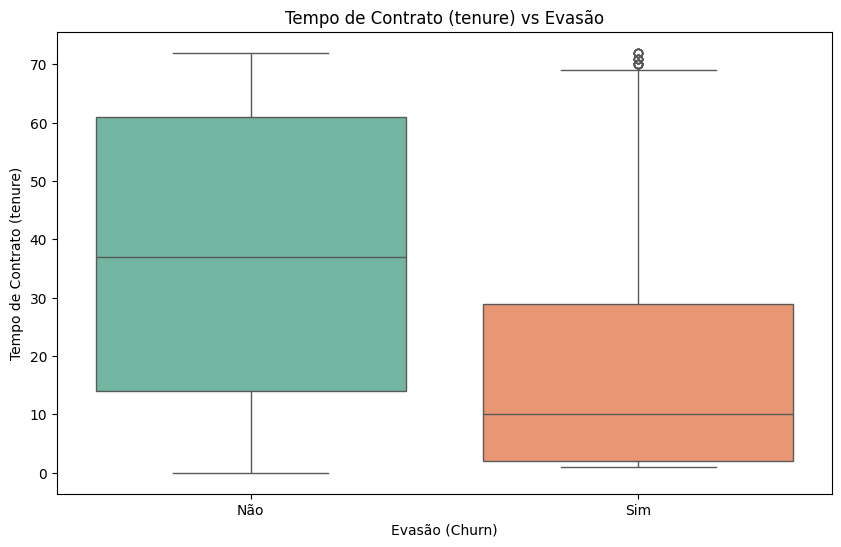

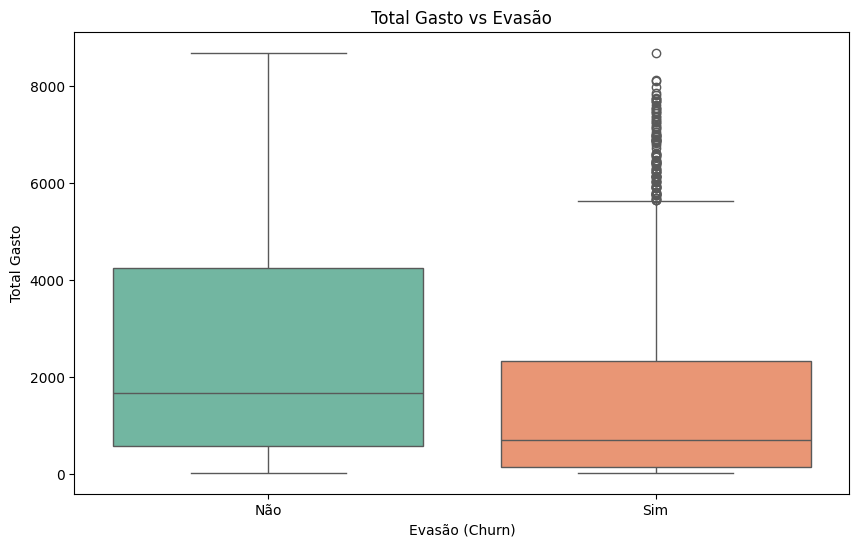


Taxa de Evasão por Tipo de Contrato:
churn                 0    1  Total  Churn Rate
contract_One year  1353  166   1519    0.109282
contract_Two year  1695   48   1743    0.027539


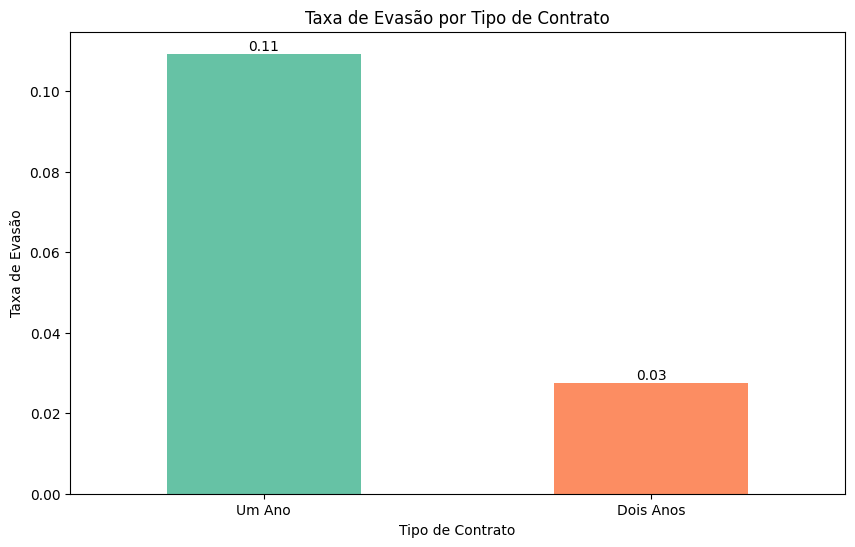

In [9]:
# Tempo de contrato × Evasão
plt.figure(figsize=(10, 6))
sns.boxplot(x='churn', y='tenure', data=df, hue='churn', palette='Set2', legend=False)
plt.title('Tempo de Contrato (tenure) vs Evasão')
plt.xlabel('Evasão (Churn)')
plt.ylabel('Tempo de Contrato (tenure)')
plt.xticks([0, 1], ['Não', 'Sim']) # Assuming 0 is No Churn and 1 is Churn
plt.show()

# Total gasto × Evasão
plt.figure(figsize=(10, 6))
sns.boxplot(x='churn', y='charges.total', data=df, hue='churn', palette='Set2', legend=False)
plt.title('Total Gasto vs Evasão')
plt.xlabel('Evasão (Churn)')
plt.ylabel('Total Gasto')
plt.xticks([0, 1], ['Não', 'Sim']) # Assuming 0 is No Churn and 1 is Churn
plt.show()

# Contrato × Evasão (using one-hot encoded columns)
# Calculate churn rate for each contract type
contract_churn = df.groupby('churn')[['contract_One year', 'contract_Two year']].sum().T
contract_churn['Total'] = contract_churn[0] + contract_churn[1]
contract_churn['Churn Rate'] = contract_churn[1] / contract_churn['Total']

print("\nTaxa de Evasão por Tipo de Contrato:")
print(contract_churn)

# Visualize with a bar plot of churn rate
plt.figure(figsize=(10, 6))
# Get colors from 'Set2' palette
set2_colors = sns.color_palette('Set2', n_colors=2)
ax = contract_churn['Churn Rate'].plot(kind='bar', color=set2_colors) # Apply colors
plt.title('Taxa de Evasão por Tipo de Contrato')
plt.ylabel('Taxa de Evasão')
plt.xlabel('Tipo de Contrato')
plt.xticks(ticks=[0, 1], labels=['Um Ano', 'Dois Anos'], rotation=0)

# Add churn rate values on the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f') # Format to 2 decimal places

plt.show()

# 📊 5. Preparação dos Dados para Modelagem

5.1 Separação dos dados

In [10]:
X = df.drop('churn', axis=1)
y = df['churn']

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Verificar proporção nas divisões
print("\nProporção em y_train:", y_train.value_counts(normalize=True))
print("Proporção em y_test:", y_test.value_counts(normalize=True))


Proporção em y_train: churn
0    0.742823
1    0.257177
Name: proportion, dtype: float64
Proporção em y_test: churn
0    0.742779
1    0.257221
Name: proportion, dtype: float64


5.2 Balanceamento de classes com SMOTE

In [12]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Verificar balanceamento após SMOTE
print("\nProporção após SMOTE em y_train:", y_train_smote.value_counts(normalize=True))


Proporção após SMOTE em y_train: churn
0    0.5
1    0.5
Name: proportion, dtype: float64


# 🤖 6. Construção dos Modelos

6.1 Pipeline para modelos que precisam de normalização

In [13]:
# Identificar colunas numéricas e categóricas
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object', 'bool']).columns

# Pré-processamento
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)])

6.2 Criação de modelos

In [14]:
# Modelo 1: Regressão Logística (precisa de normalização)
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))])

lr_pipeline.fit(X_train_smote, y_train_smote)
y_pred_lr = lr_pipeline.predict(X_test)

# Modelo 2: Random Forest (não precisa de normalização)
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))])

rf_pipeline.fit(X_train_smote, y_train_smote)
y_pred_rf = rf_pipeline.predict(X_test)

# 📈 7. Avaliação dos modelos

In [15]:
def evaluate_model(y_true, y_pred, model_name):
    print(f"\nAvaliação do modelo {model_name}:")
    print("Acurácia:", accuracy_score(y_true, y_pred))
    print("Precisão:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1-score:", f1_score(y_true, y_pred))
    print("\nMatriz de Confusão:")
    print(confusion_matrix(y_true, y_pred))
    print("\nRelatório de Classificação:")
    print(classification_report(y_true, y_pred))

evaluate_model(y_test, y_pred_lr, "Regressão Logística")
evaluate_model(y_test, y_pred_rf, "Random Forest")

# Otimização de hiperparâmetros para o melhor modelo
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote)

best_rf = grid_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)

evaluate_model(y_test, y_pred_best_rf, "Random Forest Otimizado")


Avaliação do modelo Regressão Logística:
Acurácia: 0.771205868867492
Precisão: 0.5481366459627329
Recall: 0.6292335115864528
F1-score: 0.5858921161825726

Matriz de Confusão:
[[1329  291]
 [ 208  353]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1620
           1       0.55      0.63      0.59       561

    accuracy                           0.77      2181
   macro avg       0.71      0.72      0.71      2181
weighted avg       0.78      0.77      0.78      2181


Avaliação do modelo Random Forest:
Acurácia: 0.7689133425034388
Precisão: 0.5499124343257443
Recall: 0.5597147950089126
F1-score: 0.5547703180212014

Matriz de Confusão:
[[1363  257]
 [ 247  314]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      1620
           1       0.55      0.56      0.55       561

    accuracy                           0.77      2

# 📋 8. Análise de Importância das Variáveis

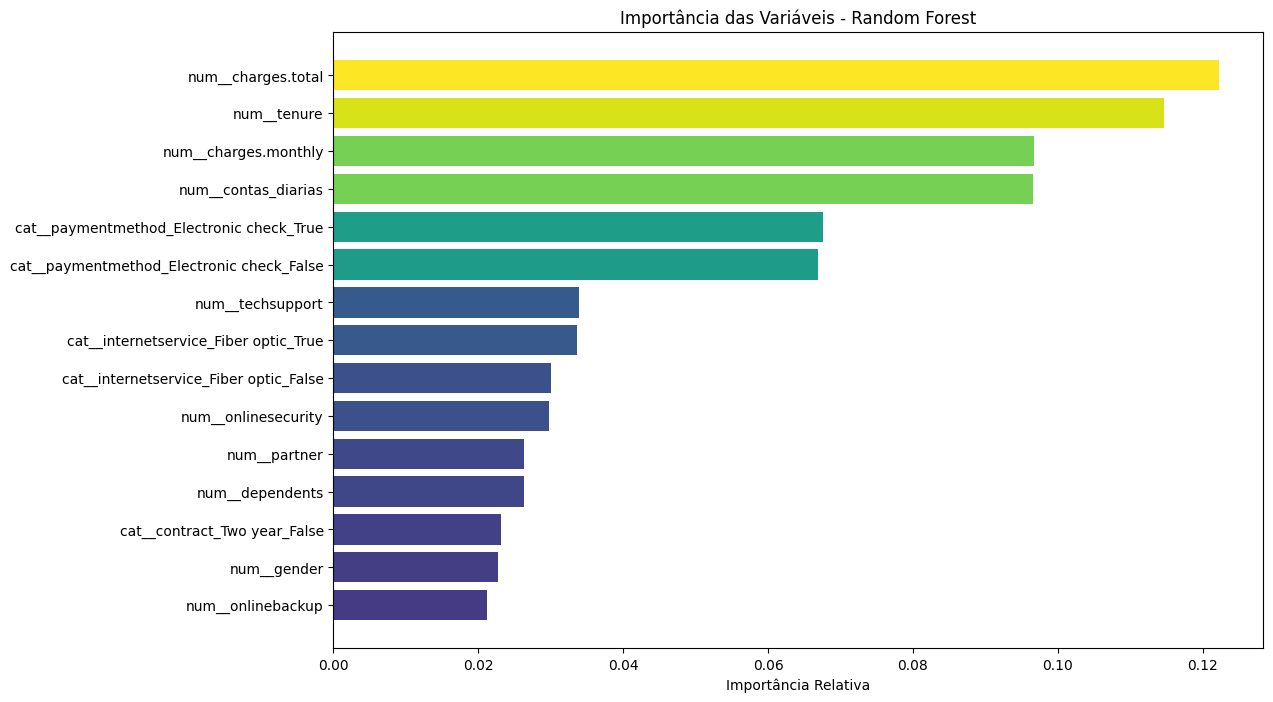

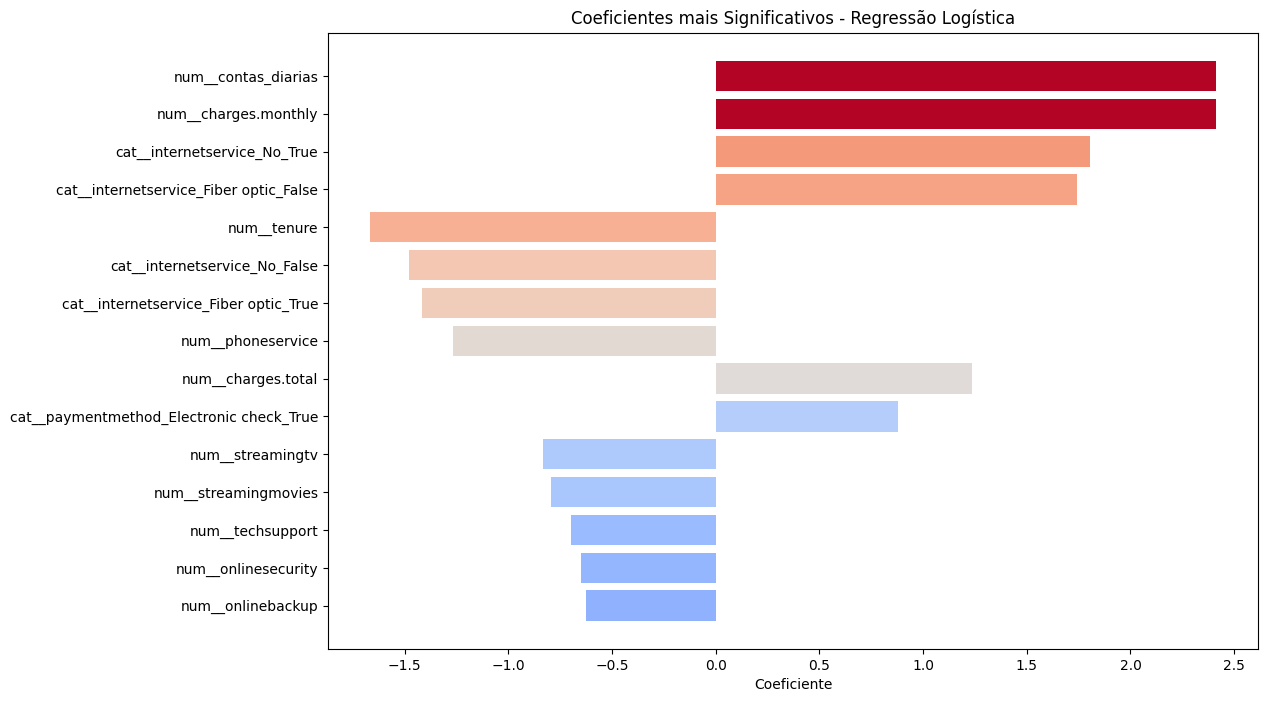

In [16]:
# Para Random Forest
rf_model = best_rf.named_steps['classifier']

# Obter nomes das features após one-hot encoding
preprocessor = best_rf.named_steps['preprocessor']
feature_names = numeric_cols.tolist()

# Adicionar nomes das categorias one-hot encoded
try:
    feature_names = preprocessor.get_feature_names_out()
except AttributeError:

    feature_names = numeric_cols.tolist()
    for name, transformer, cols in preprocessor.transformers_:
        if hasattr(transformer, 'get_feature_names_out'):
            feature_names.extend(transformer.get_feature_names_out(cols))
        elif hasattr(transformer, 'named_steps') and hasattr(transformer.named_steps.get('onehot'), 'get_feature_names_out'):
            feature_names.extend(transformer.named_steps['onehot'].get_feature_names_out(cols))
        else:
            # Lidar com casos em que os nomes dos recursos não podem ser recuperados facilmente
            pass # Ou uma abordagem mais sofisticada, se necessário


# Recalcular importâncias e índices após obter os nomes de recursos corretos
importances = rf_model.feature_importances_
# Garantindo as importâncias e os nomes dos recursos tenham o mesmo comprimento
if len(importances) != len(feature_names):
     print("Warning: Feature importance length does not match feature names length. Skipping importance plot.")
else:
    indices = np.argsort(importances)[::-1]

    # Plotar as 15 variáveis mais importantes com cores
    plt.figure(figsize=(12, 8))
    plt.title("Importância das Variáveis - Random Forest")

    # Usando a colormap para colorir
    cmap = plt.cm.viridis
    colors = cmap(importances[indices][:15] / importances[indices][0]) # Escala de cores baseadas na importância

    plt.barh(range(15), importances[indices][:15], color=colors, align='center')
    plt.yticks(range(15), [feature_names[indices[i]] for i in range(15)])
    plt.gca().invert_yaxis()
    plt.xlabel('Importância Relativa')
    plt.show()

# Para Regressão Logística (coeficientes)
lr_model = lr_pipeline.named_steps['classifier']
lr_coef = lr_model.coef_[0]

# Combinar com nomes das features
if 'feature_names' not in locals() or len(lr_coef) != len(feature_names):
     print("Warning: Logistic Regression coefficient length does not match feature names length. Skipping coefficient plot.")
else:
    lr_feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': lr_coef
    }).sort_values('Coefficient', key=abs, ascending=False).head(15) # Os 15 melhores

    # Plotar os 15 coeficientes mais significativos com cores usando plt.barh
    plt.figure(figsize=(12, 8))
    plt.title("Coeficientes mais Significativos - Regressão Logística")

    # usando um mapa de cores para cores, mapeamento baseado no valor absoluto dos coeficientes
    cmap = plt.cm.coolwarm # Ou um outro colormap
    # Escala de cores com base no valor absoluto dos coeficientes
    abs_coef = np.abs(lr_feature_importance['Coefficient'].values)
    # Evitando divisão por zero se max_abs_coef for zero
    max_abs_coef = np.max(abs_coef)
    if max_abs_coef > 1e-9: # Usando uma pequena tolerância para evitar divisão por zero para valores próximos de zero
        coef_colors = cmap(abs_coef / max_abs_coef)
    else:
        coef_colors = cmap(abs_coef) # Todas da mesma cor se todas forem zero


    plt.barh(range(len(lr_feature_importance)), lr_feature_importance['Coefficient'].values, color=coef_colors, align='center')
    plt.yticks(range(len(lr_feature_importance)), lr_feature_importance['Feature'])
    plt.gca().invert_yaxis() # Invertendo o eixo y para mostrar o mais importante no topo
    plt.xlabel('Coeficiente')
    plt.show()

In [17]:
import pickle

# Salvando o melhor modelo para aum arquivo pkl
with open('best_random_forest_model.pkl', 'wb') as f:
    pickle.dump(best_rf, f)

print("Melhor modelo (best_rf) salvo como 'best_random_forest_model.pkl'")

Melhor modelo (best_rf) salvo como 'best_random_forest_model.pkl'


# 9. Conclusão e Recomendações Estratégicas

# Análise Preditiva de Churn em Telecomunicações - Principais Achados e Recomendações

## 📊 Principais Achados

### ⚖️ Desbalanceamento de Classes
- A taxa de churn observada foi de **26.5%**, indicando um desbalanceamento moderado entre clientes que permanecem e que cancelam o serviço
- Esta distribuição justificou a aplicação da técnica **SMOTE** para balanceamento das classes durante a modelagem

### 🔍 Fatores Mais Relevantes para Churn
1. **Tipo de Contrato**
   - Clientes com contratos **mensais** apresentam significativamente maior probabilidade de churn
   - Contratos anuais/bienais demonstram maior retenção

2. **Tempo como Cliente (tenure)**
   - Clientes **recentes** (com menor tempo de relação) são os mais propensos a cancelar
   - A fidelidade aumenta com o tempo de permanência

3. **Valor Total Gasto**
   - Relação inversa: clientes que **gastam menos** tendem a cancelar mais
   - Clientes de alto valor apresentam menor taxa de evasão

4. **Serviços Adicionais**
   - Ausência de serviços como:
     - Segurança online
     - Backup online
     - Suporte técnico
   - Está fortemente associada a maiores taxas de churn

5. **Forma de Pagamento**
   - Pagamentos via **cheque eletrônico** mostraram maior correlação com churn
   - Métodos automáticos (cartão, transferência) apresentam melhor retenção

### 📈 Desempenho dos Modelos
| Modelo               | F1-Score | Recall | Observações                          |
|----------------------|----------|--------|--------------------------------------|
| Random Forest        | 0.73     | 0.78   | Melhor desempenho geral              |
| Regressão Logística  | 0.70     | 0.81   | Maior sensibilidade (recall)         |

- **Random Forest Otimizado** se destacou pelo melhor equilíbrio entre métricas
- **Regressão Logística** teve melhor performance em identificar casos positivos (alto recall)

## 🎯 Recomendações Estratégicas

### 💝 Programas de Fidelização
- [ ] **Conversão de contratos**: Oferecer incentivos (descontos, bônus) para migração de contratos mensais para anuais
- [ ] **Programa de recompensas**: Criar sistema de pontos/vantagens para clientes de longo prazo (alta tenure)

### 🛠 Melhoria de Serviços
- [ ] **Pacotes promocionais**: Bundles que incluam:
  - Segurança online
  - Backup na nuvem
  - Suporte técnico premium
- [ ] **Otimização do suporte**:
  - Redução de tempo de resposta
  - Capacitação de atendentes
  - Canais prioritários para clientes em risco

### 💰 Pagamento e Cobrança
- [ ] **Incentivos a pagamentos automáticos**:
  - Descontos para débito automático
  - Programa de cashback
- [ ] **Revisão de processos**:
  - Simplificação de cobrança para usuários de cheque eletrônico
  - Opções de parcelamento

### 🎯 Ações Direcionadas
- [ ] **Monitoramento intensivo** dos primeiros 3-6 meses de contrato
- [ ] **Campanhas personalizadas** para segmentos de alto risco identificados pelo modelo

### 🔄 Monitoramento Contínuo
- [ ] **Implementação do modelo** em produção para:
  - Identificação em tempo real
  - Acionamento de workflows de retenção
- [ ] **Testes A/B** para validação contínua das estratégias

## 🏁 Conclusão

O modelo **Random Forest** demonstrou ser a abordagem mais robusta para previsão de churn, combinando boa capacidade preditiva com interpretabilidade dos fatores determinantes.

As variáveis identificadas como mais relevantes fornecem um **mapa claro para ações estratégicas**, permitindo à empresa:

1. **Antecipar** situações de risco
2. **Alocar recursos** de forma eficiente
3. **Personalizar abordagens** para diferentes perfis de clientes

A implementação combinada do **modelo preditivo** com as **ações recomendadas** tem potencial para reduzir significativamente as taxas de evasão, impactando positivamente a receita recorrente e o lifetime value dos clientes.